# HighDimBiff Demo

You can run this 
* either on the cluster, by first converting this notebook to a script via ''jupyter nbconvert --to script run_mc.ipynb --template=nbconv.tpl'', then calling it from the command line via a slurm script with an extra argument specifying the amount of processes that can be allocated 
    * the conversion works on all notebook cells that have a tag 'export' (view -> cell toolbar -> tags)
* interactivly on your own computer with this notebook!


In [1]:
if isdefined(:cluster)
    using ClusterManagers
    N_tasks = parse(Int, ARGS[1])
    N_worker = N_tasks 
    addprocs(SlurmManager(N_worker))
    
else
    #addprocs(3)
    import Plots
end
Pkg.update("HighBifLib")
@everywhere using LSODA
@everywhere using LightGraphs
using JLD2, FileIO, Clustering
@everywhere using DifferentialEquations
@everywhere using Distributions
@everywhere using HighBifLib  
@everywhere using HypothesisTests
# these imports invoke a lot of warnings when executed with multiple processes
# this seems to me to be more a bug of julia than an actual problem with this code
# imported on a single process there are no warnings

INFO: Updating METADATA...
INFO: Updating HighBifLib master... 023300d8 → 6f63f87b
INFO: Computing changes...
INFO: No packages to install, update or remove


# Example 1: Order Parameter of Kuramoto Osc. 

We vary the initial conditions and the coupling strength. This is just to demonstrate how these kind of experiments are setup

**To-Do/Comment:** I am still very confused why and in which cases the @everywhere is needed. In this case the code doesn't work without any of the everywheres, but this goes against most of the explanations in the documentation.

In [4]:
@everywhere N = 10
@everywhere K = 0.5
@everywhere nd = Normal(0.5, 0.5) # distribution for eigenfrequencies # mean = 0.5Hz, std = 0.5Hz
@everywhere w_i_par = rand(nd,N) 

@everywhere net = erdos_renyi(N, 0.2)
@everywhere A = adjacency_matrix(net)


@everywhere ic = zeros(N)
@everywhere ic_dist = Uniform(-pi,pi)
@everywhere kdist = Uniform(0,10)
@everywhere ic_ranges = ()->rand(ic_dist)
@everywhere N_ics = 10
#@everywhere ic_ranges = [-pi:pi/2:pi/2 for i=1:N]
#@everywhere K_range = 0.0:1:10.
@everywhere K_range = ()->rand(kdist)
@everywhere pars = kuramoto_network_parameters(K, w_i_par, N, A)

# base problem
@everywhere rp = ODEProblem(kuramoto_network, ic, (0.,500.), pars)

@everywhere tail_frac = 0.9 # 
@everywhere ko_mcp = BifAnaMCProblem(rp, ic_ranges, N_ics, pars, (:K, K_range), eval_ode_run, tail_frac)
kosol = solve(ko_mcp)

HighBifLib.myMCSol(MonteCarloSolution Solution of length 10 with uType:
Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1},Float64}, 10, 400, 4)

In [20]:
D = distance_matrix(ko_sol, parameter(ko_mcp));
k = 4
fdist = k_dist(D,k);

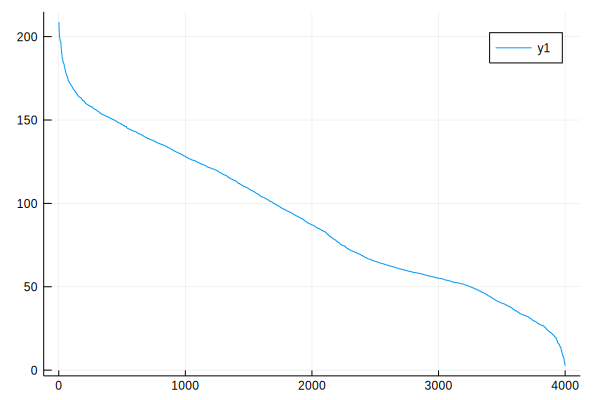

In [23]:
x = collect(1:ko_sol.N_mc)
Plots.plot(x[1:end],fdist[1:end])

In [24]:
db_eps = 150
db_res = dbscan(full(D),db_eps,k)


Clustering.DbscanResult([1, 2, 117, 1318, 2377, 3450, 3901], [1, 2, 1, 2, 2, 2, 2, 1, 2, 2  …  2, 1, 2, 1, 2, 1, 2, 2, 2, 2], [1481, 2135, 162, 10, 4, 3, 4])

In [25]:
cluster_meas = cluster_measures(ko_sol,db_res);
cluster_n = cluster_n_noise(db_res);
cluster_members = cluster_membership(parameter(ko_mcp),db_res,0.2,0.05);

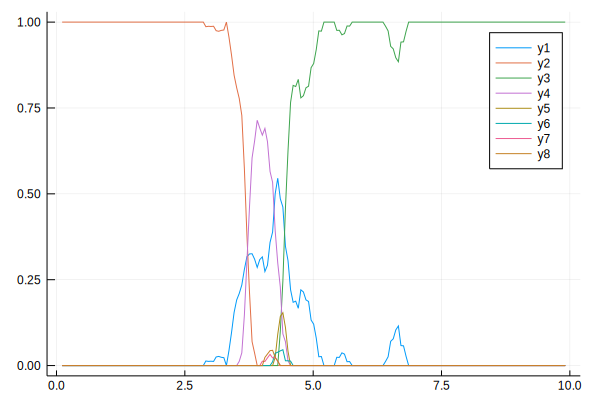

In [26]:
using Plots
plot(cluster_members[1],cluster_members[2])

# Example 2: Logistic Map

In [5]:
@everywhere rdist = Uniform(2.5,4)
@everywhere icdist = Uniform(0.1,0.99)
@everywhere r = ()->rand(rdist)
@everywhere pars = logistic_parameters(r())
@everywhere ic_ranges = ()->rand(icdist)
@everywhere N_ic = 1000
@everywhere dp = DiscreteProblem(logistic, ic_ranges(), (0.,5000.), pars)


In [6]:
# computes several measures for non-normality, we can later choose which ones to use 
# by adjusting the weights in the distance calculation
function eval_ode_run_all(sol, i)
    (N_dim, __) = size(sol)
    state_filter = collect(1:N_dim)
    function ad_test(u::AbstractArray, mu::Number, sig::Number) 
        if sig>1e-10
            return sqrt(OneSampleADTest(u, Normal(mu,sig)).A²)
        else 
            return 0.
        end
    end 
    eval_funcs = [empirical_1D_KL_divergence_hist]
    global_eval_funcs = []
    eval_ode_run(sol, i, state_filter, eval_funcs, global_eval_funcs)
end

tail_frac = 0.8
log_emcp = BifAnaMCProblem(dp, ic_ranges, N_ic, pars, (:r,r), eval_ode_run_all, tail_frac)
log_sol = solve(log_emcp)

if isdefined(:cluster)
    @save "mc_log.jld2" log_sol
end 

In [4]:
(ssol, sprob) = sort(log_sol, log_emcp)

(HighBifLib.myMCSol(MonteCarloSolution Solution of length 1000 with uType:
Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1}}, 1000, 400, 3), HighBifLib.BifAnaMCProblem(DiffEqBase.MonteCarloProblem with problem DiffEqBase.DiscreteProblem, 1000, 0.8, [0.721782 2.50105; 0.552398 2.50506; … ; 0.689022 3.99593; 0.808081 3.99845]))

In [5]:
show_results(log_sol, log_emcp, 2.9, 3.2)

221-element Array{Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1}},1}:
 ([0.655268], [2.39414e-15], [0.0]) 
 ([0.655268], [8.77736e-16], [0.0]) 
 ([0.655606], [1.50894e-15], [0.0]) 
 ([0.655641], [1.79328e-15], [0.0]) 
 ([0.655749], [3.68035e-15], [0.0]) 
 ([0.655885], [2.83248e-16], [0.0]) 
 ([0.656242], [6.33547e-16], [0.0]) 
 ([0.656358], [2.37501e-15], [0.0]) 
 ([0.656468], [1.5495e-15], [0.0])  
 ([0.656634], [3.23987e-16], [0.0]) 
 ([0.656784], [6.71332e-16], [0.0]) 
 ([0.656913], [8.7841e-16], [0.0])  
 ([0.657396], [3.42405e-15], [0.0]) 
 ⋮                                  
 ([0.656864], [0.138092], [2.33333])
 ([0.657117], [0.138247], [2.33333])
 ([0.656834], [0.138296], [2.33333])
 ([0.656595], [0.139957], [2.33333])
 ([0.656796], [0.140505], [2.33333])
 ([0.656502], [0.140597], [2.33333])
 ([0.656459], [0.140888], [2.33333])
 ([0.656724], [0.141003], [2.33333])
 ([0.656421], [0.14115], [2.33333]) 
 ([0.656245], [0.142346], [2.33333])
 ([0.656232], [0.142432], [2.333

In [5]:
@load "mc_log.jld2" log_sol

LoadError: [91mSystemError: opening file mc_log.jld2: No such file or directory[39m

In [6]:
# weights are [mean, std, kl_div, wasserstein, anderson-darling, curve_entropy, parameter]
D = @time distance_matrix(log_sol, parameter(log_emcp), [1,0.75,0.5,1]);
k = 4
fdist = @time k_dist(D,k);

if isdefined(:cluster)
    @save "mc_log_d.jld2" D
end

  0.431753 seconds (4.09 M allocations: 229.841 MiB, 13.79% gc time)
  0.308221 seconds (195.38 k allocations: 25.509 MiB, 2.25% gc time)


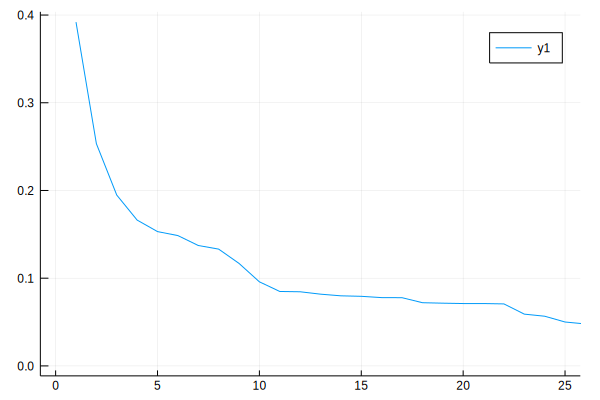

In [7]:
x = collect(1:log_sol.N_mc)
Plots.plot(x[1:end],fdist[1:end],xlim=[0,25])

In [12]:
db_eps = 0.05

0.05

In [13]:
db_res = dbscan(full(D),db_eps,k)


Clustering.DbscanResult([1, 2, 3, 5, 14, 22, 72, 312], [1, 2, 3, 1, 4, 3, 3, 4, 4, 2  …  2, 2, 0, 1, 5, 3, 3, 1, 3, 3], [57, 311, 320, 24, 85, 159, 13, 8])

In [18]:
cluster_meas = cluster_measures(log_sol,db_res);
cluster_n = cluster_n_noise(db_res);
cluster_members = cluster_membership(parameter(log_emcp),db_res,0.005,0.001);

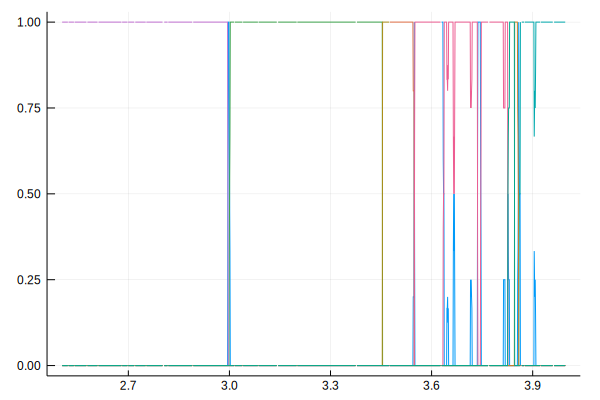

In [19]:
using Plots
plot(cluster_members[1],cluster_members[2],legend=false)

# Example 3: Roessler Network

In [10]:
@everywhere N = 5

@everywhere k = 2
@everywhere p = 0.2
@everywhere net = watts_strogatz(N, k, p)

#@everywhere A = [0 1 1 
#    1 0 1 
#    1 1 0 ]
#@everywhere net = Graph(A)

@everywhere L = laplacian_matrix(net)

@everywhere a = ones(N).*0.2
@everywhere b = ones(N).*0.2
@everywhere c = ones(N).*7.0

tail_frac = 0.8

# for reference get the synchronizable range of Ks
evals = eig(full(L))[1]
evals = sort!(evals[evals .> 1e-5])
lambda_min = evals[end]
lambda_max = evals[1]
K_sync = (0.1232/lambda_min, 4.663/lambda_max)

(0.034051642517202586, 3.374178497908152)

In [11]:
#@everywhere K_range = [0.002, 0.004, 0.006, 0.008, 0.010, 0.03, 0.05, 0.1, 0.2, 0.5, 1, 2, 4]
@everywhere K_range = [0.002, 0.004, 0.03, 0.5, 1, 4]
#@everywhere K_range = [0.002, 0.005, 0.01, 0.025, 0.05, 0.07, 0.5, 1, 2]
#@everywhere K_range = [0.005, 0.007, 0.009, 0.011, 0.013, 0.016, 0.02, 0.03, 0.04, 0.9, 1.5, 2]
@everywhere ic_gen_xy = Uniform(-15.,15.)
@everywhere ic_gen_z = Uniform(-5.,20.)

@everywhere ic_gens = [()->rand(ic_gen_xy), ()-> rand(ic_gen_xy), ()->rand(ic_gen_z)]
@everywhere N_ic = 5


@everywhere rp = ODEProblem(roessler_network, zeros(3*N), (0.,100.), roessler_parameters(a,b,c,0.05,L,N))
@everywhere (ic_coupling_problem, ic_par, N_mc) = setup_ic_par_mc_problem(rp, ic_gens, N_ic, roessler_parameters(a,b,c,0.05,L,N),(:K,K_range))


In [5]:
rn_mcp = MonteCarloProblem(rp, prob_func=ic_coupling_problem, output_func=eval_ode_run_inf)
rn_emcp = EqMCProblem(rn_mcp, N_mc, tail_frac)
@time rn_sol = solve(rn_emcp)

@save "mc_roes_sol.jld2" rn_sol ic_par rn_emcp

if isdefined(:cluster)
    @save "mc_roes_sol.jld2" rn_sol ic_par rn_emcp
end 

  5.997917 seconds (35.68 M allocations: 865.371 MiB, 3.45% gc time)


In [2]:
@load "mc_roes_sol.jld2" rn_sol ic_par rn_empc
#@load "mc_roes_ic_par_inf.jld2" ic_par

LoadError: [91mKeyError: key "rn_empc" not found[39m

In [ ]:
D = distance_matrix(rn_sol);
k = 4
fdist = k_dist(D,k);

In [ ]:
x = collect(1:rn_sol.N_mc)
Plots.plot(x[1:end],fdist[1:end])

In [ ]:
eps = 6e8
db_res = dbscan(D,eps,k)
cluster_meas = cluster_measures(rn_sol, db_res)

# Example 4: Lotka Volterra

High Dimensional (N>=4) Lotka Volterra system can exhibit all kinds of interessting dynamics. Maybe it makes sense to study them with these tools

First we study the 4-dim model: $\frac{dN_i}{dt} = b_iN_i\left(1-\sum_{j=1}^n a_{ij}N_j\right),\qquad 1\leq i\leq n$

The parameter configuration

$ a = \left[ \begin{array}{cccc}
        1 & 1.09 & 1.52 & 0\\
        0 & 1 & 0.44 & 1.36\\
        2.33 & 0 & 1 & 0.47\\
        1.21 & 0.51 & 0.35 & 1\\
        \end{array} \right] $
        
$ b = \left(1, 0.72, 1.53, 1.27\right)$

is known to exhibit chaos with a strange attractor. Lets scan around these parameters.

In [9]:
@everywhere N = 4

@everywhere a = [1 1.09 1.52 0
                 0 1 0.44 1.36
                 2.33 0 1 0.47
                 1.21 0.51 0.35 1
                ]
@everywhere b = [1, 0.72, 1.53, 1.27]

@everywhere a12 = 0.69:0.1:2.59
@everywhere var_a = [a for i=1:length(a12)]
for i=1:length(a12)
        var_a[i][1,2] = a12[i]
end 

tail_frac = 0.8
@everywhere ic_gen = Uniform(-0.99,0.99)

@everywhere ic_gens = [()->rand(ic_gen)]
@everywhere N_ic = 100

@everywhere lvp = ODEProblem(lotka_volterra, zeros(N), (0.,100.), lotka_volterra_parameters(a,b,N))
@everywhere (ic_a_problem, ic_par, N_mc) = setup_ic_par_mc_problem(lvp, ic_gens, N_ic, lotka_volterra_parameters(a,b,N),(:a,var_a))


LoadError: [91m[91m[91mUndefVarError: Uniform not defined[39m
eval(::Module, ::Any) at ./boot.jl:235
eval_ew_expr at ./distributed/macros.jl:116 [inlined]
(::Base.Distributed.##135#136{Base.Distributed.#eval_ew_expr,Tuple{Expr},Array{Any,1}})() at ./distributed/remotecall.jl:319
run_work_thunk(::Base.Distributed.##135#136{Base.Distributed.#eval_ew_expr,Tuple{Expr},Array{Any,1}}, ::Bool) at ./distributed/process_messages.jl:56
#remotecall_fetch#140(::Array{Any,1}, ::Function, ::Function, ::Base.Distributed.LocalProcess, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:344
remotecall_fetch(::Function, ::Base.Distributed.LocalProcess, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:344
#remotecall_fetch#144(::Array{Any,1}, ::Function, ::Function, ::Int64, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:372
remotecall_fetch(::Function, ::Int64, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:372
(::##85#87)() at ./distributed/macros.jl:102[39m
#remotecall_fetch#140(::Array{Any,1}, ::Function, ::Function, ::Base.Distributed.LocalProcess, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:345
remotecall_fetch(::Function, ::Base.Distributed.LocalProcess, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:344
#remotecall_fetch#144(::Array{Any,1}, ::Function, ::Function, ::Int64, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:372
remotecall_fetch(::Function, ::Int64, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:372
(::##85#87)() at ./distributed/macros.jl:102[39m

In [8]:
lvp_mcp = MonteCarloProblem(lvp, prob_func=ic_a_problem, output_func=eval_ode_run_repeat)
lvp_emcp = EqMCProblem(lvp_mcp, N_mc, tail_frac)
@time lvp_sol = solve(lvp_emcp)

if isdefined(:cluster)
    @save "mc_lv_sol.jld2" lvp_sol
    @save "mc_lv_ic_par.jld2" ic_par
end 

4×4 Array{Float64,2}:
 1.0   2.59  1.52  0.0 
 0.0   1.0   0.44  1.36
 2.33  0.0   1.0   0.47
 1.21  0.51  0.35  1.0 

# Example 5: Henon Map

In [ ]:
@everywhere a = 2.5:0.02:4
@everywhere pars = henon_parameters(1,1)
@everywhere ic_ranges = [0.1:0.005:0.9]
@everywhere hmp = DiscreteProblem(henon, ic_ranges[1][1], (0.,500.), pars)
@everywhere (ic_r_prob, ic_par, N_mc) = setup_ic_par_mc_problem(hmp, ic_ranges, pars, (:a, a))

hm_mcp = MonteCarloProblem(dp, prob_func=ic_r_prob, output_func=eval_ode_run)
tail_frac = 0.8
hm_emcp = EqMCProblem(hm_mcp, N_mc, tail_frac)
hm_sol = solve(hm_emcp)

if isdefined(:cluster)
    @save "mc_log.jld2" hm_sol
end 